<a href="https://colab.research.google.com/github/samyarsworld/nuclei-segmentation/blob/main/image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nuclei Segmentation

## 1. Install Segmentation Library and Change Runtime:
* Change the Colab runtime to support the latest available GPU (T4 at this time)
* Install segmentation models. Nothing for now.

## 2. Download the dataset and helper functions:

Repository address: https://github.com/samyarsworld/nuclei-segmentation


In [2]:
%cd /content
%rm -rf nuclei-segmentation
!git clone https://github.com/samyarsworld/nuclei-segmentation
%cd nuclei-segmentation

/content
Cloning into 'nuclei-segmentation'...
remote: Enumerating objects: 32354, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 32354 (delta 3), reused 4 (delta 1), pack-reused 32342
Receiving objects: 100% (32354/32354), 79.88 MiB | 39.79 MiB/s, done.
Resolving deltas: 100% (11124/11124), done.
Updating files: 100% (30200/30200), done.
/content/nuclei-segmentation


In [3]:
BASE_TRAIN_PATH = 'data/train/'
BASE_TEST_PATH = 'data/test/'

## 3. Import Required Libraries and Functions:

In [4]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob

from tqdm import tqdm
from PIL import Image
import random
from skimage.transform import resize

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

from helper_functions import plot_transformed_images, plot_images

## 4. Setup Initial Configurations:

In [5]:
# Configure device agnostic model (preferably on GPU)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Setup constants
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# Setup path to data folder
BASE_TRAIN_PATH = 'data/train/'
BASE_TEST_PATH = 'data/test/'



## 5. Validate the dataset:

The mask of the image is devided to 10s of images of the same size, only showing one nuclei per image. To be able to compare to the main image, we need to combine all the masks of the corresponding image together. Below is the algorithm:

In [6]:
def combine_masks(id, shape):
  mask_folder_path = os.path.join(BASE_TRAIN_PATH, id, "masks")
  masks = glob(mask_folder_path + "/*.png")
  combined_mask = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3))

  for mask_path in masks:
    mask = np.asarray(Image.open(mask_path))
    mask = resize(img, shape, mode="constant", preserve_range=True)
    combined_mask = np.maximum(combined_mask, mask)

  return combined_mask

(-0.5, 127.5, 127.5, -0.5)

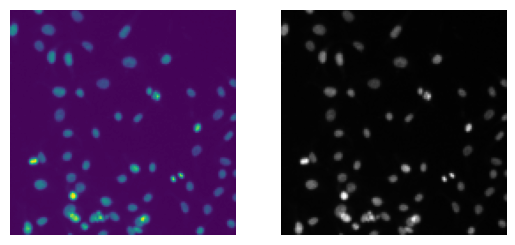

In [7]:
random.seed(42)
# Get the list of training data
train_obj = os.scandir(BASE_TRAIN_PATH)
train_ids = [x.name for x in train_obj]

# Get a random image index
ind = random.randint(0, len(train_ids) - 1)
id = train_ids[ind]

img_path = os.path.join(BASE_TRAIN_PATH, id, "images", id + ".png")
img = np.asarray(Image.open(img_path))[:,:,:IMG_CHANNELS]
img = resize(img, (IMG_WIDTH, IMG_HEIGHT), mode="constant", preserve_range=True)
mask = combine_masks(id, img.shape)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img[:, :, 0])
ax1.axis("off")

ax2.imshow(mask[:, :, 0], cmap="gray")
ax2.axis("off")



### 5. Setup Transformation

In [8]:
# Transform train data function
data_transformer = transforms.Compose([
    # Resize the images
    transforms.Resize(size=(IMG_WIDTH, IMG_HEIGHT)),
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

Check out how the transformation is changing the images:

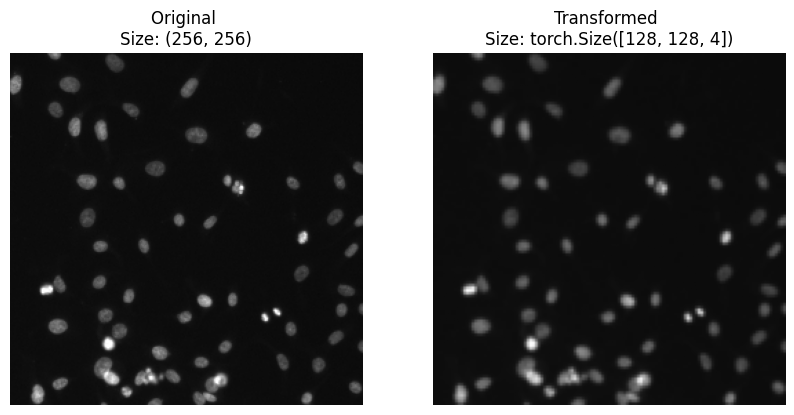

In [8]:
plot_transformed_images([img_path], data_transformer, n=1)

### 6. Create Custom Dataset

In [77]:
class ImageDataset(Dataset):
  def __init__(self, base_dir: str, train=True, transform=None) -> None:
    self.base_dir = base_dir
    self.transform = transform
    self.train = train

    # Get the list of training data
    train_obj = os.scandir(base_dir)
    train_ids = sorted([x.name for x in train_obj])
    self.image_paths = [os.path.join(base_dir, id, "images", id + ".png") for id in train_ids]

    if train:
      self.mask_folder_paths = [os.path.join(self.base_dir, id, "masks") for id in train_ids]

  def combine(self, mask_folder_path):
    masks = glob(mask_folder_path + "/*.png")
    shape = np.asarray(Image.open(masks[0])).shape
    combined_mask = np.zeros(shape)

    for mask_path in masks:
      mask = np.asarray(Image.open(mask_path))
      combined_mask = np.maximum(combined_mask, mask)
    return combined_mask

  def load_data(self, index: int) -> Image.Image:
    img = np.asarray(Image.open(self.image_paths[index]))
    # Check the number of channels
    if img.shape[-1] == 4:
      img = img[:, :, :3]  # Keep only the RGB channels

    img = Image.fromarray(img.astype(np.uint8))

    mask = None
    if self.train:
      mask = self.combine(self.mask_folder_paths[index])
      mask = Image.fromarray(mask.astype(np.uint8))

    return img, mask

  def __len__(self) -> int:
    return len(self.image_paths)

  def __getitem__(self, index: int) -> torch.Tensor:
    img, mask = self.load_data(index)

    # Transform if exists
    if self.transform:
      if self.train:
        return self.transform(img), self.transform(mask)
      else:
        return self.transform(img)
    else:
      if self.train:
        return img, mask
      else:
        return img

In [80]:
dataset = ImageDataset(BASE_TRAIN_PATH, True, data_transformer)
test_dataset = ImageDataset(BASE_TEST_PATH, True, data_transformer)

### 7. Batch the Dataset

In [81]:
BATCH_SIZE = 32

train_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 8. Create the Segmentation Model

Here a Unet model is created using 2D convultional layers, max pooling, unpooling, fully connected (dense) layers, and activation functions.

Later pre-trained heavy segmentation models will be compared to this model.

In [70]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.max_pool = nn.MaxPool2d(kernel_size=2)
    # Encoders
    self.encode_conv1 = self.double_conv(3, 16)
    self.encode_conv2 = self.double_conv(16, 32)
    self.encode_conv3 = self.double_conv(32, 64)
    self.encode_conv4 = self.double_conv(64, 128)
    self.encode_conv5 = self.double_conv(128, 256)

    # Decoders
    self.decode_conv1 = self.double_conv(256, 128)
    self.decode_conv2 = self.double_conv(128, 64)
    self.decode_conv3 = self.double_conv(64, 32)
    self.decode_conv4 = self.double_conv(32, 16)

    self.decode_conv5 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=1, device=DEVICE)

    # Up poolings
    self.up_pooling1 = self.up_pooling(256, 128)
    self.up_pooling2 = self.up_pooling(128, 64)
    self.up_pooling3 = self.up_pooling(64, 32)
    self.up_pooling4 = self.up_pooling(32, 16)


  def double_conv(self, in_c, out_c):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_c, out_channels=out_c, kernel_size=3, padding=1, device=DEVICE),
        nn.ReLU(),
        nn.Dropout2d(p=0.2),
        nn.Conv2d(in_channels=out_c, out_channels=out_c, kernel_size=3, padding=1, device=DEVICE),
        nn.ReLU(),
    )

  def up_pooling(self, in_c, out_c):
    return nn.ConvTranspose2d(in_channels=in_c, out_channels=out_c, kernel_size=2, stride=2, padding=0, device=DEVICE)


  def forward(self, x):
    # Encoder
    x1 = self.encode_conv1(x)
    x2 = self.encode_conv2(self.max_pool(x1))
    x3 = self.encode_conv3(self.max_pool(x2))
    x4 = self.encode_conv4(self.max_pool(x3))
    x5 = self.encode_conv5(self.max_pool(x4))

    # Decoder
    x5 = self.up_pooling1(x5)
    x4 = self.decode_conv1(torch.cat((x5, x4), dim=1))

    x4 = self.up_pooling2(x4)
    x3 = self.decode_conv2(torch.cat((x4, x3), dim=1))

    x3 = self.up_pooling3(x3)
    x2 = self.decode_conv3(torch.cat((x3, x2), dim=1))

    x2 = self.up_pooling4(x2)
    x1 = self.decode_conv4(torch.cat((x2, x1), dim=1))

    logits = self.decode_conv5(x1)

    return logits


### 9. Create Train and Validation Function

In [59]:
### Training Setup

def train(data_loader, model, optimizer, loss_fn):
  tot_loss = 0.0

  # Set the enviornment to train
  model.train()

  # Loop through batches (with progress bar)
  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    # Calculate the predictions (logits)
    logits = model(images)

    # Calculate the loss
    loss = loss_fn(logits, masks)

    # Set grads to zero
    optimizer.zero_grad()

    # Perform back propagation
    loss.backward()

    # Update weights and biases using ADAM
    optimizer.step()

    # Add batch loss to total loss
    tot_loss += loss.item()

  return tot_loss / (len(data_loader))

In [52]:
### Testing Setup

def test(data_loader, model, loss_fn):
  tot_loss = 0.0

  # Set the environment to evaluation/inference mode
  model.eval()

  with torch.inference_mode():
    # Loop through batches (with progress bar)
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      # Calculate the predictions (logits)
      logits = model(images)

      # Calculate the loss
      loss = loss_fn(logits, masks)

      # Add batch loss to total loss
      tot_loss += loss.item()

  return tot_loss / (len(data_loader))

### 10. Train Model

In [72]:
LR = 0.01

# Model initialization
model = SegmentationModel().to(DEVICE)

# Optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

# Loss functions
BCE_loss = nn.BCEWithLogitsLoss()

In [82]:
EPOCHS = 5
best_test_loss = np.Inf
test_loss = None

for epoch in tqdm(range(EPOCHS)):
  train_loss = train(train_loader, model, optimizer=optimizer, loss_fn=BCE_loss)
  # test_loss = test(test_loader, model, loss_fn=BCE_loss)

  # if test_loss < best_test_loss:
  #   best_test_loss = test_loss
  #   torch.save(model.state_dict(), "model.pt")
  #   print("Model updated!")

  print(f"Iteration: {epoch}, Training loss: {train_loss}, Testing loss: {test_loss}")


100%|██████████| 1/1 [00:43<00:00, 43.71s/it]

Iteration: 0, Training loss: 0.2597757450171879, Testing loss: None


### 11. Inference and Predictions

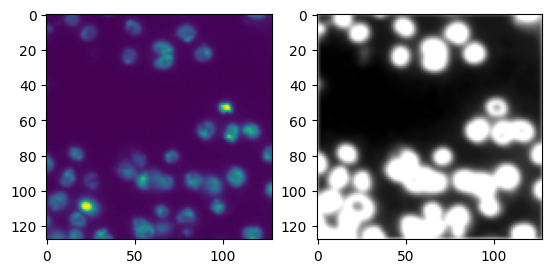

In [101]:
# model.load_state_dict(torch.load("/content/Human-segmentation-deep-learning/model.pt"))

test_obj = os.scandir(BASE_TEST_PATH)
test_ids = [x.name for x in test_obj]
id = random.choice(test_ids)
img_path = os.path.join(BASE_TEST_PATH, id, "images", id + ".png")
img = np.asarray(Image.open(img_path))[:,:,:IMG_CHANNELS]
img = Image.fromarray(img.astype(np.uint8))
img = data_transformer(img).unsqueeze(dim=0).to(DEVICE)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img.squeeze()[1,:,:].cpu())
plt.imshow(model(img).squeeze().detach().cpu(), cmap="gray")

# logits = model(image.to(DEVICE).unsqueeze(0)) # Unsqueeze to add the batch dimension (here would be just 1)
# pred = torch.sigmoid(logits)
# pred = (pred > 0.5)

In [ ]:
# plot_images(image, target, pred.detach().cpu().squeeze(0))